## Install library (jalankan jika belum terinstall)


In [475]:
# %pip install pandas seaborn matplotlib numpy scikit-learn imbalanced-learn

# Tujuan Klasifikasi pada Dataset Fish


Tujuan dilakukannya klasifikasi ini adalah untuk mengidentifikasi Spesies Ikan Berdasarkan fitur seperti panjang (length), berat (weight), dan rasio panjang-berat (w_l_ratio).

## Alasan Memilih Multi-Layer Perceptron (MLP)

1. Kemampuan Memproses Data Non-Linear:
Dataset ini memiliki hubungan non-linear antar fitur (length, weight, w_l_ratio) dan target (species). MLP dengan beberapa hidden layers dan fungsi aktivasi dapat memodelkan hubungan kompleks ini.

2. Cocok untuk Dataset Berukuran Sedang:
Dataset ini cukup besar untuk menerapkan deep learning sederhana (MLP), namun tidak terlalu besar sehingga masih efisien menggunakan solver adam.

3. Fleksibilitas dan Efisiensi:
MLP memungkinkan eksperimen dengan berbagai fungsi aktivasi dan konfigurasi layer untuk menangkap pola unik dalam data.

# EDA

## A. Import Library

In [476]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE

### Atur konfigurasi tampilan

In [ ]:

sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)

## B. Membaca Dataset

### Membaca dataset dan melihat informasi awal

In [478]:
df = pd.read_csv('./Fish species sampling data/fish_data.csv')
print("Dataset Overview:")
df.head(n = 300)

Dataset Overview:


,species,length,weight,w_l_ratio
0,Anabas testudineus,10.66,3.45,0.32
1,Anabas testudineus,6.91,3.27,0.47
2,Anabas testudineus,8.38,3.46,0.41
3,Anabas testudineus,7.57,3.36,0.44
4,Anabas testudineus,10.83,3.38,0.31
...,...,...,...,...
295,Anabas testudineus,9.24,3.11,0.34
296,Anabas testudineus,7.55,3.34,0.44
297,Anabas testudineus,7.33,3.16,0.43
298,Anabas testudineus,8.59,3.19,0.37


In [479]:
print("\nInfo Dataset:")
df.info()


Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4080 entries, 0 to 4079
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   species    4080 non-null   object 
 1   length     4080 non-null   float64
 2   weight     4080 non-null   float64
 3   w_l_ratio  4080 non-null   float64
dtypes: float64(3), object(1)
memory usage: 127.6+ KB


### Statistik deskriptif


In [480]:
print("\nDescriptive Statistics:")
df.describe()


Descriptive Statistics:


,length,weight,w_l_ratio
count,4080.000000,4080.000000,4080.000000
mean,17.353544,3.739875,0.252782
std,7.114684,1.040365,0.123046
min,6.360000,2.050000,0.080000
25%,11.327500,3.070000,0.170000
50%,17.350000,3.310000,0.190000
75%,22.585000,4.100000,0.340000
max,33.860000,6.290000,0.640000


### Jumlah nilai unik dan nilai null

In [481]:
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


species      0
length       0
weight       0
w_l_ratio    0
dtype: int64

In [482]:
print("\nUnique Values per Column:")
df.nunique()


Unique Values per Column:


species         9
length       1857
weight        249
w_l_ratio      57
dtype: int64

## C. Distribusi Label

### Visualisasi distribusi kelas

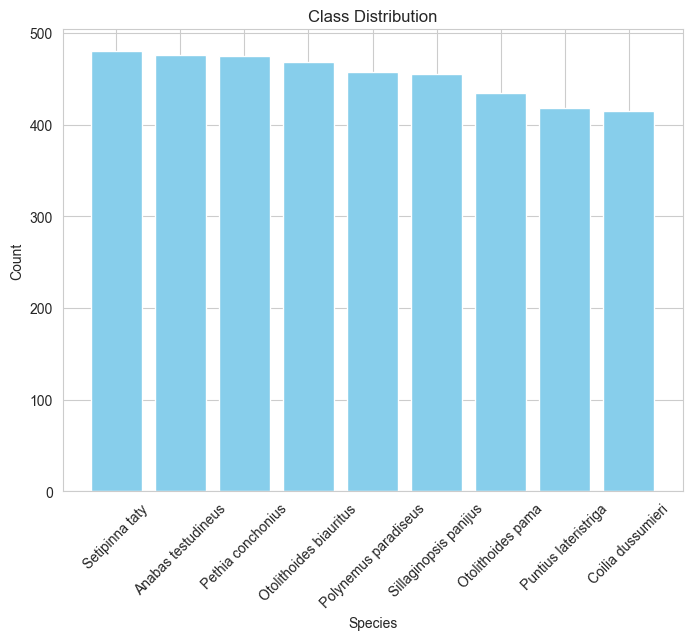

In [483]:
class_counts = df['species'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts, color="skyblue")
plt.title("Class Distribution")
plt.xlabel("Species")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

### Rasio imbalance

In [484]:
imbalance_ratio = class_counts.min() / class_counts.max()
print(f"Class Imbalance Ratio: {imbalance_ratio:.2f} (Ideal jika mendekati 1)")


Class Imbalance Ratio: 0.86 (Ideal jika mendekati 1)


## D. Analisis Data Numerik

### Pairplot untuk fitur numerik

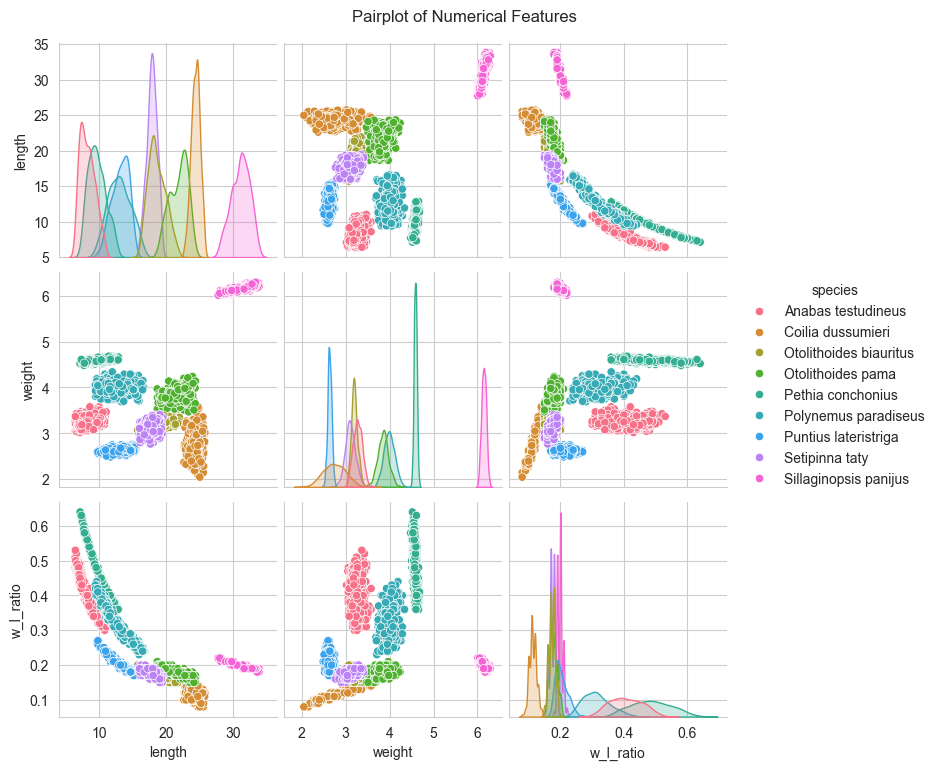

In [485]:
numerical_columns = ['length', 'weight', 'w_l_ratio']
sns.pairplot(df, vars=numerical_columns, hue='species', palette="husl", diag_kind="kde")
plt.suptitle("Pairplot of Numerical Features", y=1.02)
plt.show()

### Boxplot untuk memeriksa outlier

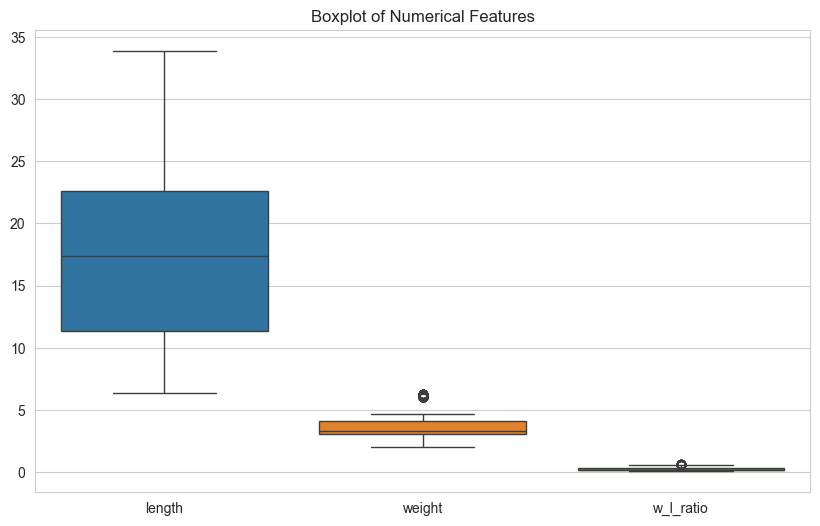

In [486]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[numerical_columns])
plt.title("Boxplot of Numerical Features")
plt.show()

## E: Deteksi Outlier

### Menggunakan Isolation Forest untuk mendeteksi outlier

In [487]:
iso = IsolationForest(contamination=0.02, random_state=42)  # Kontaminasi 2% dari total data
outlier_predictions = iso.fit_predict(df[numerical_columns])
df['Outlier'] = outlier_predictions

### Visualisasi outlier

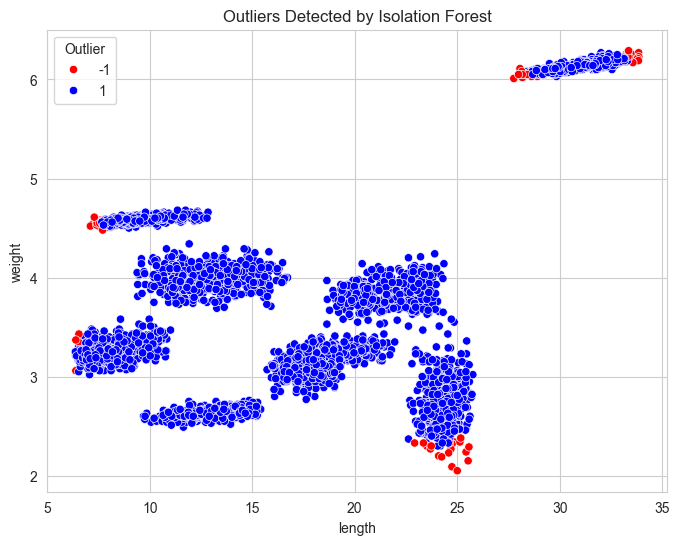

In [ ]:


plt.figure(figsize=(8, 6))
sns.scatterplot(x='length', y='weight', hue='Outlier', data=df, palette={1: 'blue', -1: 'red'})
plt.title("Outliers Detected by Isolation Forest")
plt.show()

### Menghapus data outlier

In [ ]:

print("\nDataset sebelum outlier dihapus:", df.shape)
df = df[df['Outlier'] == 1]
df.drop(columns=['Outlier'], inplace=True)
print("\nDataset setelah outlier dihapus:", df.shape)


Dataset sebelum outlier dihapus: (4080, 5)

Dataset setelah outlier dihapus: (3998, 4)


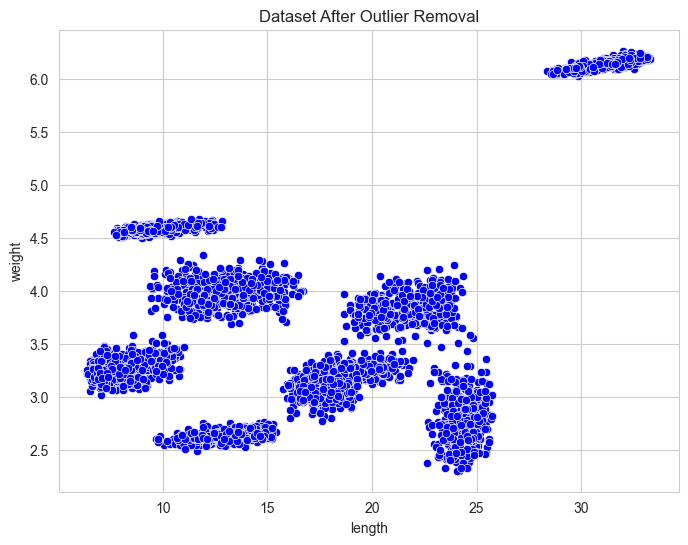

In [516]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='length', y='weight', data=df, color='blue')
plt.title("Dataset After Outlier Removal")
plt.show()

## F. Feature Engineering

### Menambah fitur baru (log transform pada 'weight')

In [491]:
df['log_weight'] = np.log1p(df['weight'])

## G. Encoding dan Class Imbalance


### Label encoding untuk kolom 'species'

In [492]:
label_encoder = LabelEncoder()
df['species'] = label_encoder.fit_transform(df['species'])


### Memisahkan fitur dan label

In [493]:
X = df[numerical_columns + ['log_weight']]
y = df['species']

### Mengatasi class imbalance dengan SMOTE

In [494]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

### Visualisasi distribusi kelas setelah SMOTE

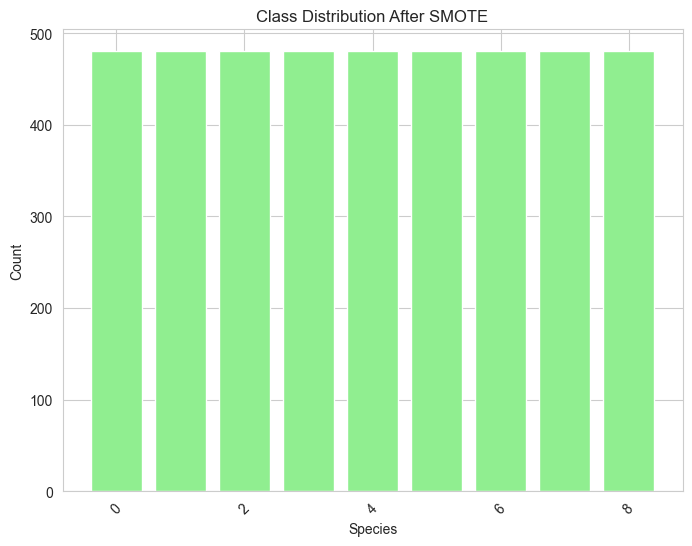

In [495]:
resampled_counts = pd.Series(y_resampled).value_counts()
plt.figure(figsize=(8, 6))
plt.bar(resampled_counts.index, resampled_counts, color="lightgreen")
plt.title("Class Distribution After SMOTE")
plt.xlabel("Species")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

### Visualisasi heatmap korelasi setelah penambahan fitur

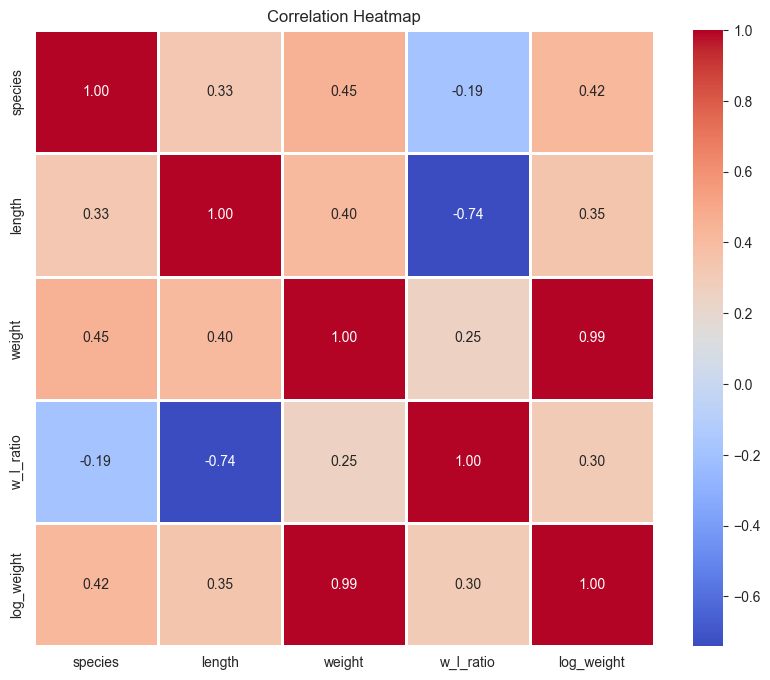

In [496]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=2)
plt.title("Correlation Heatmap")
plt.show()

## H. Dataset Siap untuk Modeling


### Dataset siap untuk digunakan dalam proses modeling

In [497]:
print("\nFinal Dataset Shape:", X_resampled.shape)
print("\nSample of Resampled Dataset:")
print(pd.DataFrame(X_resampled, columns=X.columns).head())


Final Dataset Shape: (4320, 4)

Sample of Resampled Dataset:
   length  weight  w_l_ratio  log_weight
0   10.66    3.45       0.32    1.492904
1    6.91    3.27       0.47    1.451614
2    8.38    3.46       0.41    1.495149
3    7.57    3.36       0.44    1.472472
4   10.83    3.38       0.31    1.477049


# Modeling

## A. Split Dataset untuk Training dan Testing


In [498]:
from sklearn.model_selection import train_test_split

### Split dataset menjadi data training dan testing

In [499]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)


### Cek ukuran data

In [500]:
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (3024, 4)
Testing set size: (1296, 4)


## B. Standarisasi Data


In [501]:
from sklearn.preprocessing import StandardScaler


### Inisialisasi StandardScaler

In [502]:
scaler = StandardScaler()

### Fit dan transform data training

In [503]:
X_train_scaled = scaler.fit_transform(X_train)

### Transform data testing (menggunakan scaler yang sama)

In [504]:
X_test_scaled = scaler.transform(X_test)

### Konfirmasi standarisasi

In [505]:
print("Contoh data setelah standarisasi (Training):")
print(X_train_scaled[:5])

Contoh data setelah standarisasi (Training):
[[ 0.0415493  -0.53563166 -0.56983945 -0.51270747]
 [-1.09342301  0.86530147  1.83353795  0.96770668]
 [-1.29743399  0.82756191  2.49653861  0.9331335 ]
 [ 1.9915933   2.34435475 -0.48696436  2.16122313]
 [ 2.01975278  2.32515485 -0.48696436  2.14744227]]


## C. Membangun Model Multi-Layer Perceptron (MLP)


In [506]:
from sklearn.neural_network import MLPClassifier

### Inisialisasi model MLP

In [507]:

mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # Dua hidden layers dengan masing-masing 100 dan 50 neuron
    
    # ReLU (Rectified Linear Unit): Mengubah input negatif menjadi nol, dan mempertahankan input positif.
    # logistic (sigmoid): Untuk data biner atau probabilitas.
    # tanh: Untuk data yang terpusat di sekitar nol.
    # identity: Fungsi linear tanpa aktivasi.
    activation='tanh', 
    
    
    # adam (Adaptive Moment Estimation): Kombinasi antara momentum dan metode adaptive learning rate. Cepat dan efisien, cocok untuk dataset besar dan parameter kompleks.
    # sgd (Stochastic Gradient Descent): Untuk kasus sederhana, membutuhkan lebih banyak tuning.
    # lbfgs: Solver berbasis optimasi kedua untuk dataset kecil.
    solver='adam',
    
    max_iter=10000, # Jumlah maksimal iterasi
    random_state=42
)

### Train model menggunakan data training

In [508]:
mlp_model.fit(X_train_scaled, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 50), max_iter=10000,
              random_state=42)

### Konfirmasi training selesai

In [509]:
print("Training completed.")

Training completed.


## D. Evaluasi Model


In [510]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

### Prediksi pada data testing

In [511]:
y_pred = mlp_model.predict(X_test_scaled)

### Evaluasi performa model

In [512]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(f"{accuracy_score(y_test, y_pred) * 100:.2f}%")


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       144
           1       1.00      0.99      0.99       144
           2       0.75      0.85      0.80       144
           3       0.99      1.00      0.99       144
           4       1.00      1.00      1.00       144
           5       1.00      1.00      1.00       144
           6       1.00      1.00      1.00       144
           7       0.83      0.72      0.77       144
           8       1.00      1.00      1.00       144

    accuracy                           0.95      1296
   macro avg       0.95      0.95      0.95      1296
weighted avg       0.95      0.95      0.95      1296


Accuracy Score:
95.06%


### Confusion Matrix

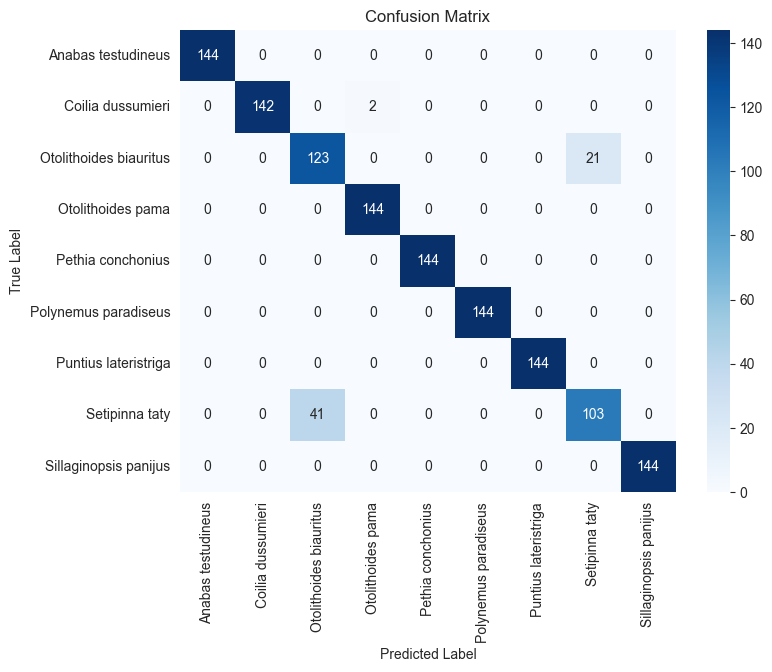

In [523]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()

### Evaluasi Stabilitas

In [514]:
from sklearn.model_selection import cross_val_score

In [521]:
scores = cross_val_score(mlp_model, X_train_scaled, y_train, cv=10)

# Membuat DataFrame untuk hasil cross-validation
cv_results = pd.DataFrame({
    "Fold": range(1, len(scores) + 1),
    "Accuracy": scores
})

# Menambahkan rata-rata ke DataFrame
cv_results.loc["Average"] = ["-", scores.mean()]

# Menampilkan hasil dalam bentuk tabel
print("\nCross-validation Results:")
print(cv_results)


Cross-validation Results:
        Fold  Accuracy
0          1  0.933993
1          2  0.953795
2          3  0.943894
3          4  0.953795
4          5  0.947020
5          6  0.950331
6          7  0.943709
7          8  0.943709
8          9  0.953642
9         10  0.937086
Average    -  0.946098
